<a href="https://colab.research.google.com/github/afrojaakter/Natural-Language-Processing/blob/main/TextGenerationRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will work on a character-based RNN to generate text. I will use a dataset of Shakespear's writing. Given a sequence of characters (e.g., 'Shakespear') from the data, I will train a model to predict the next character in the sequence (e.g., 'e'). Longer sequence of text can be generated by calling the model repeatedly. 

In [2]:
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing


### Downdload the dataset

In [3]:
path = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [4]:
# Read the data and the decode for py2 compat
text = open(path, 'rb').read().decode(encoding='utf-8')
#length of text is the number of characters in it
print(f'Lenght of text: {len(text)} characters')

Lenght of text: 1115394 characters


In [5]:
# First 250 characters in the text
print(text[: 250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# Unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### Data Preprocessing
#### Vectorize the text data: We need to convert the strings to a numerical representation
```preprocessing.StringLookup``` layer will convert string to a numerical value. It requires text to be split into tokens first.


In [8]:
example_texts = ['abcde','pqrt' 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
print(chars)

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e'], [b'p', b'q', b'r', b't', b'x', b'y', b'z']]>


In [9]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)

In [10]:
# converts form tokens to character IDs
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44], [55, 56, 57, 59, 63, 64, 65]]>

Since we want to generate text, we use ```preprocessing.StringLoopup(..., invert = True)``` to recover human readable string.


In [11]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary = ids_from_chars.get_vocabulary(), invert = True, mask_token=None
)
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e'], [b'p', b'q', b'r', b't', b'x', b'y', b'z']]>

In [13]:
# 'tf.strings.reduce_join' to join the characters back into strings
tf.strings.reduce_join(chars, axis = -1).numpy()

array([b'abcde', b'pqrtxyz'], dtype=object)

In [21]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Prediction task
We want to know, given a character or a sequence of characters, what is the most probable next character is. 

The input of the model is a sequence of characters and the trained model will predict the following character at each time step. 

#### Create training examples and targets
We need to divide the text into example sequences. Each input sequence will contain ```seq_length``` characters from the text. 

For each input sequence, the corresponding target contains the same length of text, except the shifted one character to the right. 

So, we break the text into chuns of ```seq_length + 1```. 
For example, say ```seq_length = 4``` and out text is "Hello". The input sequence would be "Hell" and the target sequence would be "ello". 

To do this first we will use ```tf.data.Dataset.from_tensor_slices``` function to convert the text vector into a stram of character indices.



In [14]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [17]:
print(text[:10])
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

First Citi
F
i
r
s
t
 
C
i
t
i


In [18]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length + 1)

In [19]:
# batch method convert these individual characters to sequences of desired size.
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)
for seq in sequences.take(1):
  print(chars_from_ids(seq))


tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [22]:
# Lets see what is happending by joining the tokens back into strings
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training we will need a dataset of ```(input, label)``` pairs. Where the input and the label both are sequences. 

At each time step the input is the current character and the label is the next character.



In [29]:
def split_input_target(sequence):
  ''' Takes a sequence as input, duplicates and shifts it to align the input
  and label for each timestep'''
  input_seq = sequence[:-1]
  target_seq = sequence[1:]
  return input_seq, target_seq

split_input_target(list("Hello"))

(['H', 'e', 'l', 'l'], ['e', 'l', 'l', 'o'])

In [30]:
dataset = sequences.map(split_input_target)

In [33]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target :", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target : b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#### Creating training batches
Before feeding the splitted text data into the model, we need to shuffle the data and peak it into batches.


In [37]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire suquenc in memory. 
# Insted, it maintains a buffer in which it shuffles elements).

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))
dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

#### Build the model


In [38]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

class MyModel(tf.keras.Model):
  '''The model has three layers:
  1. Embedding layer: The input layer. A trainable lookup table that will map each
    character-ID to a vector with embedding_dim dimensions;
  2. GRU: One type of RNN with size = rnn_units
  3. Dense: The output layer with size = vocab_size
    It outputs one logit for each character in the vocabulary. 
    These are the log-likelihood of each character according to the model. 
  '''
  
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units, 
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)
  
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state = states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else: return x

In [40]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()), 
    embedding_dim = embedding_dim,
    rnn_units=rnn_units
  )

For each character the model looks up the embedding, runs the GPU one timestep with char embedding as input and applies the dense layer to generate logits predicting the log-likelihood of the next character. 

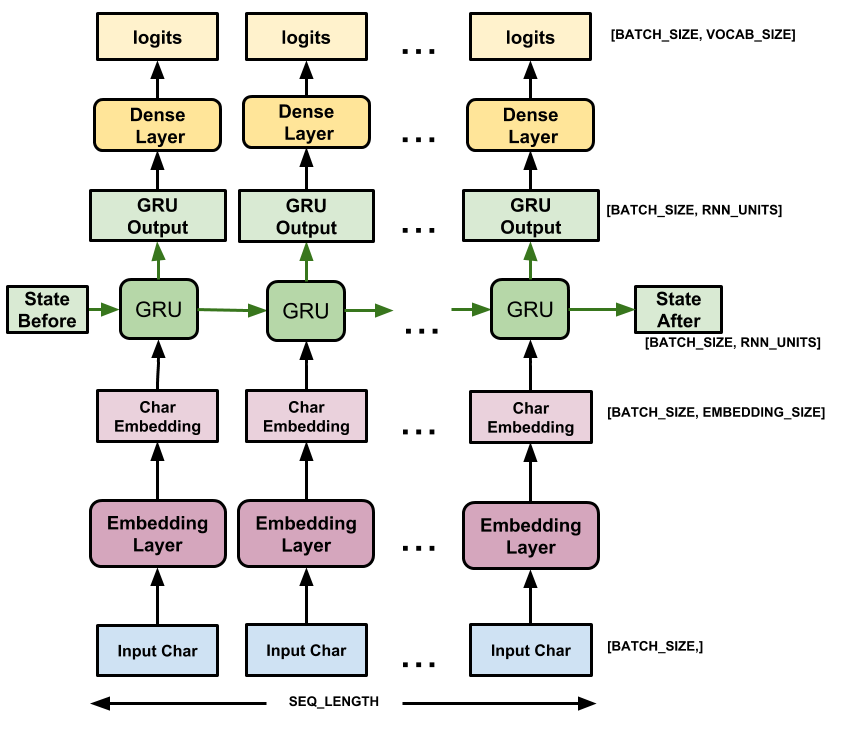

In [45]:
# checking the shape of the output is (batch_size, sequence_length, vocab_size)
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictins = model(input_example_batch)
  print("(batch_size, sequence_length, vocab_size) :", example_batch_predictins.shape)

(batch_size, sequence_length, vocab_size) : (64, 100, 66)


Even though the sequence_length of the input is 100, model can run on inputs of any lenght. 

In [46]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  16896     
_________________________________________________________________
gru_1 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_1 (Dense)              multiple                  67650     
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [47]:
# let's try for the first example in the batch
sampled_indices = tf.random.categorical(example_batch_predictins[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
#This gives us a prediction of the next character index at each timestep
sampled_indices

array([ 4, 37, 47, 43, 52, 45, 39, 23, 13, 34, 49, 44,  5, 54, 15, 23, 51,
       36, 49,  7, 65, 35, 43, 22,  6, 48, 26, 27, 42, 18,  8,  2, 24, 55,
       48,  2, 42,  4,  0, 52, 21, 23, 21, 42, 23, 15,  0, 12, 41, 56, 41,
       65, 50, 15,  5, 46,  0, 41, 55, 24, 11, 64, 64, 55, 48, 65, 10, 47,
       31, 52,  1, 63, 17, 30, 53, 30, 49, 22, 37, 38, 30, 33, 43, 53, 18,
        5, 21,  5,  3, 26, 20, 25, 42, 52, 25,  6, 52, 26, 49, 38])

In [48]:
# Decode to see the text predicted by untrained model
print("Input :\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions :\n", text_from_ids(sampled_indices).numpy())

Input :
 b" I had title in thy noble husband!\nI have bewept a worthy husband's death,\nAnd lived by looking on h"

Next Char Predictions :
 b"$XhdmfZJ?Uje&oBJlWj,zVdI'iMNcE- Kpi c$[UNK]mHJHcJB[UNK];bqbzkB&g[UNK]bpK:yypiz3hRm\nxDQnQjIXYQTdnE&H&!MGLcmL'mMjY"


#### Train the model
At this point the problem can be treated as a standart calssification problem. Given the previous RNN state, and the input this time step, predict the class of the next character. 

The standart 'sparse categorical crossentropy' loss function works in this case  because it is applied across the last dimension of the predictions. 

In [49]:
#Since the model returns logits, we need to set 'from_logits=True'
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [52]:
example_batch_loss = loss(target_example_batch, example_batch_predictins)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape :", example_batch_predictins.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape : (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.189849
